# BYO Container Example:  lightGBM

In this notebook we'll examine how to BYO container in Amazon SageMaker.  This is an option for algorithms and frameworks not directly supported in Amazon SageMaker as either (1) built-in algorithms, or (2) prebuilt Amazon SageMaker containers (such as the ones for TensorFlow, PyTorch, Apache MXNet, Scikit-learn, and XGBoost).  As an example, we'll containerize the popular lightGBM gradient boosting framework, which is not supported off-the-shelf in Amazon SageMaker, and apply it to a public dataset from UCI's Machine Learning Repository.  The dataset, which relates to predicting purchase intent by online shoppers, is at https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset.  

Besides BYO container, we'll also employ the following features:  SageMaker Processing for data preprocessing, SageMaker hosted training, SageMaker Processing for model evaluation/batch scoring, and endpoints for real time inference.  More specifically, we'll perform the following steps:

TODO: rewrite
- Obtain the dataset.
- Build a Docker image for lightGBM to be run as a container in SageMaker Processing.
- Preprocess the data with that image in SageMaker Processing.
- Build a separate Docker image for lightGBM for training models with SageMaker hosted training.
- Train a lightGBM model with that separate Docker image in SageMaker hosted training.
- Evaluate the model / do batch scoring in SageMaker Processing with the same container used for preprocessing.
- Deploy the model to a real time SageMaker endpoint using Ezsmdeploy, a Python package that provides many conveniences and automation.

**PREREQUISITES:**  Be sure to run this notebook on an instance or machine that supports Docker, with AWS IAM permissions to Amazon S3 and Amazon SageMaker (full access to both is fine for learning purposes).  In the notebook below we'll also add access to Amazon ECR.

**DO NOT SELECT "RUN ALL" CELLS**


## Setup

We'll begin with updating version of Sagemaker Python SDK and some imports that will be useful throughout the notebook, and set up some objects and variables we'll need.

In [ ]:
!{sys.executable} -m pip install --upgrade sagemaker

In [ ]:
%matplotlib inline

import boto3
import sys
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
session = sagemaker.Session()
s3_output = session.default_bucket()
s3_prefix = 'lightGBM-BYO'

Before we move on, let's add access via AWS IAM to Amazon ECR, a fully-managed Docker container registry that makes it easy to store, manage, and deploy Docker container images.  Later in this notebook we'll create Docker repositories in ECR and push Docker images to them.

To do this, perform the following steps:

- In a separate browser tab, open the IAM console:  https://console.aws.amazon.com/iam
- In the left panel/tray, click **Roles**.
- Click on the name of your role as printed above (it will be the characters after the right-most "/" character).
- Click on the **Attach policies** button.
- In the search box, type **ec2containerregistry**; you should now see a list of policies that include the substring "AmazonEC2ContainerRegistry".
- Click the box next to **AmazonEC2ContainerRegistryFullAccess**.
- Click **Attach policy**.

Continue with the rest of the notebook, your role will be updated almost instantaneously.  

## Obtain dataset

Next we'll download the dataset.

In [ ]:
!mkdir -p raw
!wget -P ./raw https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv

Let's inspect the data briefly now, just to confirm it was properly downloaded.

In [272]:
import pandas as pd

df = pd.read_csv('./raw/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


The target we'd like to predict is the Revenue column, which is `True` if an online purchase transaction was completed.  As you might expect, a relatively small number of transactions are actually completed, resulting in a class imbalance we can handle various ways with lightGBM.

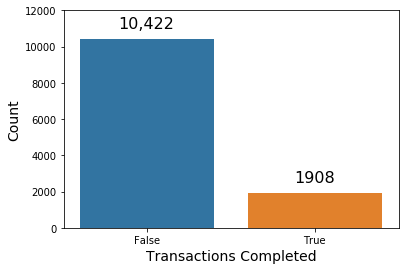

In [273]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

sns.countplot(df['Revenue'])
plt.ylim(0,12000)
plt.xlabel('Transactions Completed', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.text(x=-.175, y=11000 ,s='10,422', fontsize=16)
plt.text(x=.875, y=2500, s='1908', fontsize=16)
plt.show()

Since Exploratory Data Analysis (EDA) is not the focus of this example, we'll now move on to upload the raw data to S3 so it can be accessed by SageMaker.

In [ ]:
rawdata_s3_prefix = '{}/raw'.format(s3_prefix)
raw_s3 = session.upload_data(path='./raw/', key_prefix=rawdata_s3_prefix)
print(raw_s3)

## SageMaker Experiments setup

SageMaker Experiments allows us to keep track of data preprocessing and model training; organize related models together; and log model configuration, parameters, and metrics to reproduce and iterate on previous models and compare models. We'll create a single experiment to keep track of the different approaches we'll use to train the model.

Each approach or block of preprocessing or training code that we run can be an experiment trial. Later, we'll be able to compare different trials.  To start, we'll install the SageMaker Experiments SDK.

In [ ]:
!{sys.executable} -m pip install sagemaker-experiments requests

Only a few parameters are required to create the SageMaker Experiments object itself.

In [ ]:
from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker
import time

lightgbm_experiment = Experiment.create(
    experiment_name=f"lightgbm-{int(time.time())}", 
    description="Purchase intent prediction with lightGBM", 
    sagemaker_boto_client=boto3.client('sagemaker'))
print(lightgbm_experiment)

## Docker image for data preprocessing and model evaluation

Before any further steps can be completed for SageMake Processing with lightGBM, we need to build a Docker image.  We'll build one image first, and use that same image for multiple purposes:

- Preprocessing data; and
- Evaluating the model (batch scoring).

A separate, but very similar, Docker image will be used for training below.  

To begin, we'll create a new directory for Docker-related files and write a Dockerfile.

In [ ]:
!mkdir -p docker-proc-evaluate

A simple Dockerfile can be used to build the container.  Of particular note are the following statements in the Dockerfile:
- FROM statement:  this sets the parent image.  There are many choices, considerations include size (smaller may be better), "up-to-dateness", stability, and security.  The chosen image is based on a slim version of Debian 10 ("Buster").  
- RUN statements:  used here primarily to install dependencies.  Only a few are required.  Note that libgomp1 is a library used by lightgbm, but is not included in this version of Debian.
- ENTRYPOINT statement:  specifies the command used to run the scripts that will be included in the container by SageMaker.  In our case, they are ordinary Python 3 scripts so the command is simply `python3`.

In [ ]:
%%writefile docker-proc-evaluate/Dockerfile

FROM python:3.7-slim-buster
RUN apt -y update && apt install -y --no-install-recommends \
    libgomp1 \
    && apt clean    
RUN pip3 install lightgbm numpy pandas scikit-learn 
ENV PYTHONUNBUFFERED=TRUE
ENTRYPOINT ["python3"]

This block of code builds the image using various Docker commands, creates an Amazon ECR repository, and pushes the image to Amazon ECR.

In [ ]:
import boto3

region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')
ecr_repository = 'lightgbm-byo-proc-eval'
tag = ':latest'
uri_suffix = 'amazonaws.com'
processing_repository_uri = '{}.dkr.ecr.{}.{}/{}'.format(account_id, region, uri_suffix, ecr_repository + tag)

# Create ECR repository and push docker image
!docker build -t $ecr_repository docker-proc-evaluate
!$(aws ecr get-login --region $region --registry-ids $account_id --no-include-email)
!aws ecr create-repository --repository-name $ecr_repository
!docker tag {ecr_repository + tag} $processing_repository_uri
!docker push $processing_repository_uri

Your Docker image has all required dependencies, and enables you to run your own preprocessing, feature engineering, and model evaluation scripts all within the same container in a robust and repeatable way. 

To integrate the image with SageMaker, simply reference it in the SageMaker Python SDK's `ScriptProcessor` class, which lets you execute a command to run your own script inside a container based on this image.

In [ ]:
from sagemaker.processing import ScriptProcessor

script_processor = ScriptProcessor(command=['python3'],
                image_uri=processing_repository_uri,
                role=role,
                instance_count=1,
                instance_type='ml.c5.xlarge')

## Preprocess data with SageMaker Processing

Some preprocessing should be performed on this dataset before training.  For example, the data must be normalized, and split into train and test sets.  Below is a preprocessing script.  It is an ordinary Python script with very little specific to SageMaker.  To comply with SageMaker, the script must read the input data from a specified directory, and save the preprocessed data to certain directories so it can be automatically uploaded to S3 by SageMaker at the end of the job.  

In [ ]:
%%writefile preprocessing.py

import glob
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split


if __name__=='__main__':
    
    input_file = glob.glob('{}/*.csv'.format('/opt/ml/processing/input'))
    print('\nINPUT FILE: \n{}\n'.format(input_file))   
    df = pd.read_csv(input_file[0])
    
    # minor preprocessing (drop some uninformative columns etc.)
    print('Preprocessing the dataset . . . .')   
    df_clean = df.drop(['Month','Browser','OperatingSystems','Region','TrafficType','Weekend'], axis=1)
    visitor_encoded = pd.get_dummies(df_clean['VisitorType'], prefix='Visitor_Type', drop_first = True)
    df_clean_merged = pd.concat([df_clean, visitor_encoded], axis=1).drop(['VisitorType'], axis=1)
    X = df_clean_merged.drop('Revenue', axis=1)
    y = df_clean_merged['Revenue']
    
    # split the preprocessed data with stratified sampling for class imbalance
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2, test_size=.2)

    # save to container directory for uploading to S3
    print('Saving the preprocessed dataset . . . .')   
    train_data_output_path = os.path.join('/opt/ml/processing/train', 'x_train.npy')
    np.save(train_data_output_path, X_train.to_numpy())
    train_labels_output_path = os.path.join('/opt/ml/processing/train', 'y_train.npy')
    np.save(train_labels_output_path, y_train.to_numpy())    
    test_data_output_path = os.path.join('/opt/ml/processing/test', 'x_test.npy')
    np.save(test_data_output_path, X_test.to_numpy())
    test_labels_output_path = os.path.join('/opt/ml/processing/test', 'y_test.npy')
    np.save(test_labels_output_path, y_test.to_numpy())   

Now the `ScriptProcessor` object created above can be used to run this `preprocessing.py` script. As mentioned above, the primary requirements are specifying input and output directories.  Here, there are two outputs because the transformed train and test data are sent to different folders in S3.  We also include an `experiment_config` parameter so this data preprocessing step can be tracked as part of a SageMaker Experiment and added to model lineage.

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from time import gmtime, strftime 

processing_job_name = "lightgbm-byo-process-{}".format(strftime("%d-%H-%M-%S", gmtime()))
output_destination = 's3://{}/{}/data'.format(s3_output, s3_prefix)

script_processor.run(code='preprocessing.py',
                      job_name=processing_job_name,
                      inputs=[ProcessingInput(
                        source=raw_s3,
                        destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='train',
                                                destination='{}/train'.format(output_destination),
                                                source='/opt/ml/processing/train'),
                               ProcessingOutput(output_name='test',
                                                destination='{}/test'.format(output_destination),
                                                source='/opt/ml/processing/test')],
                      experiment_config={
                            "ExperimentName": lightgbm_experiment.experiment_name,
                            "TrialComponentDisplayName": "Processing",
                      }
                    )

preprocessing_job_description = script_processor.jobs[-1].describe()

After the job is complete, it is easy to look up the location of the output in S3.  The code below retrieves the S3 URLs of the locations of the transformed train and test data.  These will be used as inputs to futher jobs below.  

In [ ]:
output_config = preprocessing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'train':
        preprocessed_training_data = output['S3Output']['S3Uri']
        print(preprocessed_training_data)
    if output['OutputName'] == 'test':
        preprocessed_test_data = output['S3Output']['S3Uri']
        print(preprocessed_test_data)

We also can download the preprocessed test data for later use.  

In [ ]:
session.download_data(path='.', bucket=s3_output, key_prefix=s3_prefix+'/data/test/x_test.npy')

During the SageMaker Processing job, a SageMaker Experiments trial component was associated with it so we can include it when tracking model lineage.  We can inspect all of the information automatically logged by the Experiment Tracker during the job:

In [ ]:
for trial in lightgbm_experiment.list_trials():
    proc_job = trial
    break
    
lightgbm_tracker = Tracker.load(proc_job.trial_name)
preprocessing_trial_component = lightgbm_tracker.trial_component
print(preprocessing_trial_component)

## Train a model with lightGBM

There are multiple different ways to train a model in SageMaker.  One of the simplest ways to do so is to reuse the same container from above within SageMaker Processing itself to do the training.  This is possible due to the fact that the `ScriptProcessor` object we instantiated above can ingest an arbitrary Python script as long as we specify the input and output locations in S3.  

An alternative is to use SageMaker hosted training.  Like SageMaker Processing, SageMaker hosted training spins up a right-sized, transient cluster for your job and then shuts it down when the job is done.  This enables you to do most of your work in lower-cost notebooks while reserving full scale training and related costs for only when you need it.  Using SageMaker hosted training offers several advantages over SageMaker Processing for training.  These include easy integrations with:  SageMaker Debugger, SageMaker Experiments, SageMaker Search, Managed Spot Training, Automatic Model Tuning, options for multiple file sources/channels with automated data shuffling and sharding, and more.  

To use SageMaker hosted training, we'll create another simple Docker image.  We'll create another directory first.

In [ ]:
!mkdir -p docker-train

The Dockerfile for training is similar to the first one, with a few key differences:  
- The parent image is from another ML framework's Docker image that bundles a bunch of necessary low-level build tools for the sagemaker-containers package (see next bullet point).  Another parent with those tools could be substituted.
- There is one additional Python package:  sagemaker-containers, which integrates the container with SageMaker hosted training.
- An environment variable indicating which Python module is the entry point for training.

Note that you do NOT need to include the training script in the Docker image.  The sagemaker-containers package allows you to pass in a training script from an Amazon S3 location dynamically each time you start a training job, so you can reuse the same Docker image without rebuilding it for code changes.

In [ ]:
%%writefile docker-train/Dockerfile

FROM python:3.7-slim-buster
RUN apt -y update && apt install -y --no-install-recommends \
    libgomp1 build-essential \
    && apt clean    
RUN pip install lightgbm numpy pandas scikit-learn sagemaker-training
ENV SAGEMAKER_PROGRAM train.py
ENV PYTHONUNBUFFERED=TRUE

Now we'll create a separate ECR repository for the training images, build the new training image, and push it.

In [ ]:
ecr_repository_train = 'lightgbm-byo-train'
uri_suffix = 'amazonaws.com'
train_repository_uri = '{}.dkr.ecr.{}.{}/{}'.format(account_id, region, uri_suffix, ecr_repository_train + tag)

# Create ECR repository and push docker image
!docker build -t $ecr_repository_train docker-train
!$(aws ecr get-login --region $region --registry-ids $account_id --no-include-email)
!aws ecr create-repository --repository-name $ecr_repository_train
!docker tag {ecr_repository_train + tag} $train_repository_uri
!docker push $train_repository_uri

Below is the training script.  Again, it is very similar to a Python script you would use outside SageMaker, and the main SageMaker-specific requirements are that you must specify several arguments from which you will extract hyperparameters such as the learning rate.  

In [ ]:
%%writefile docker-train/train.py

import argparse
import glob
import lightgbm as lgb
import numpy as np
import os


if __name__=='__main__':
    
    # extract training data S3 location and hyperparameter values
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])
    parser.add_argument('--validation', type=str, default=os.environ['SM_CHANNEL_VALIDATION'])
    parser.add_argument('--num_leaves', type=int, default=28)
    parser.add_argument('--max_depth', type=int, default=5)
    parser.add_argument('--learning_rate', type=float, default=0.1)
    args = parser.parse_args()
    
    print('Loading training data from {}\n'.format(args.train))
    input_files = glob.glob('{}/*.npy'.format(args.train))
    print('\nTRAINING INPUT FILE LIST: \n{}\n'.format(input_files)) 
    for file in input_files:
        if 'x_' in file:
            x_train = np.load(file)
        else:
            y_train = np.load(file)      
    print('\nx_train shape: \n{}\n'.format(x_train.shape))
    print('\ny_train shape: \n{}\n'.format(y_train.shape))
    train_data = lgb.Dataset(x_train, label=y_train)
    
    print('Loading validation data from {}\n'.format(args.validation))
    eval_input_files = glob.glob('{}/*.npy'.format(args.validation))
    print('\nVALIDATION INPUT FILE LIST: \n{}\n'.format(eval_input_files)) 
    for file in eval_input_files:
        if 'x_' in file:
            x_val = np.load(file)
        else:
            y_val = np.load(file)      
    print('\nx_val shape: \n{}\n'.format(x_val.shape))
    print('\ny_val shape: \n{}\n'.format(y_val.shape))
    eval_data = lgb.Dataset(x_val, label=y_val)
    
    print('Training model with hyperparameters:\n\t num_leaves: {}\n\t max_depth: {}\n\t learning_rate: {}\n'
          .format(args.num_leaves, args.max_depth, args.learning_rate))
    parameters = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'is_unbalance': 'true',
        'boosting': 'gbdt',
        'num_leaves': args.num_leaves,
        'max_depth': args.max_depth,
        'learning_rate': args.learning_rate,
        'verbose': 1
    }
    num_round = 10
    bst = lgb.train(parameters, train_data, num_round, eval_data, verbose_eval=1)
    
    print('Saving model . . . .')
    bst.save_model('/opt/ml/model/online_shoppers_model.txt')

The training script must be packaged as a .tar.gz file and uploaded to S3 for access by SageMaker.  This step must be repeated every time the script is modified, but avoids having to rebuild the Docker image for code changes:  you can just reuse the same Docker image with any lightGBM training script.

In [ ]:
import tarfile
import os

def create_tar_file(source_files, target=None):
    if target:
        filename = target
    else:
        _, filename = tempfile.mkstemp()

    with tarfile.open(filename, mode="w:gz") as t:
        for sf in source_files:
            t.add(sf, arcname=os.path.basename(sf))

In [ ]:
create_tar_file(["docker-train/train.py"], "sourcedir.tar.gz")

In [132]:
sources = session.upload_data('sourcedir.tar.gz', s3_output, s3_prefix + '/code')
print(sources)

s3://sagemaker-us-east-1-553020858742/lightGBM-BYO/code/sourcedir.tar.gz


With our training script in Amazon S3, we can now set up an Amazon SageMaker Estimator object to represent the actual training job.  Similarly to the ScriptProcessor object, the Estimator takes in as parameters the Docker image, and instance type and amount.  Additionally, it takes in an encoded dictionary of hyperparameters for training.  For `train_instance_type` we specify `local`:  this allows us during the prototyping phase of a project to test SageMaker training code locally on the instance running this code.  Later in this example we will switch to a SageMaker instance type when we start multiple training jobs in parallel to find the best model.

In [ ]:
from sagemaker.estimator import Estimator
import json

def json_encode_hyperparameters(hyperparameters):
    return {str(k): json.dumps(v) for (k, v) in hyperparameters.items()}

hyperparameters = json_encode_hyperparameters({
    "sagemaker_program": "train.py",
    "sagemaker_submit_directory": sources,
    'num_leaves': 32,
    'max_depth': 3,
    'learning_rate': 0.08})

estimator = Estimator(image_uri='lightgbm-byo-train',
                      role=role,
                      instance_count=1,
                      instance_type='local',
                      hyperparameters=hyperparameters,
                      base_job_name='lightgbm-byo')

The `fit` method invocation starts the training job.

In [ ]:
estimator.fit({'train': preprocessed_training_data, 'validation': preprocessed_test_data}, logs='All')

We can easily download the trained model, whether for further use inside of Amazon SageMaker or anywhere else.

In [ ]:
!aws s3 cp {estimator.model_data} ./model/model.tar.gz
!tar -xvzf ./model/model.tar.gz -C ./model

We'll upload the unzipped version of the model back to Amazon S3 for use by SageMaker Processing in model evaluation / batch scoring. 

In [109]:
s3_model = session.upload_data('./model/online_shoppers_model.txt', s3_output, s3_prefix + '/model')
print(s3_model)

s3://sagemaker-us-east-1-553020858742/lightGBM-BYO/model/online_shoppers_model.txt


## Evalutate the model / batch scoring

Next we can reuse the Docker image from data preprocessing for model evaluation, or batch scoring.  Below is the evaluation script.  This time the main SageMaker-specific requirement is specifying an input directory.   

In [ ]:
%%writefile evaluation.py

import glob
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score


if __name__=='__main__':
    
    print('Loading data . . . .')
    input_files = glob.glob('{}/*.npy'.format('/opt/ml/processing/input'))
    print('\nINPUT FILE LIST: \n{}\n'.format(input_files)) 
    for file in input_files:
        if 'x_' in file:
            x_test = np.load(file)
        else:
            y_test = np.load(file)
            
    print('\nx_test shape: \n{}\n'.format(x_test.shape))
    print('\ny_test shape: \n{}\n'.format(y_test.shape))
 
    print('Loading model . . . .\n')    
    model_path = '/opt/ml/processing/model/'
    bst_loaded = lgb.Booster(model_file=model_path+'online_shoppers_model.txt')
    y_pred = bst_loaded.predict(x_test)
    
    print('Evaluating model . . . .\n')    
    acc = accuracy_score(y_test.astype(int), y_pred.round(0).astype(int))
    auc = roc_auc_score(y_test, y_pred)
    print('Accuracy:  {:.2f}'.format(acc))
    print('AUC Score: {:.2f}'.format(auc))

We'll also reuse the `ScriptProcessor` object we instantiated above, this time for the evaluation script.  Instead of having two outputs, as in the preprocessing job, there are two inputs:  one for the input data, and another for the model artifact to be used in the evaluation.  At the end of the job, we'll log the accuracy and AUC score metrics.  We also could have stored evaluation results to a file, or even saved visualization graphics, and asked SageMaker Processing to upload those to S3 at the end of the job.

In [ ]:
processing_job_name = "lightgbm-byo-eval-{}".format(strftime("%d-%H-%M-%S", gmtime()))
output_destination = 's3://{}/{}/eval'.format(s3_output, s3_prefix)

script_processor.run(code='evaluation.py',
                      job_name=processing_job_name,
                      inputs=[ProcessingInput(
                                source=preprocessed_test_data,
                                destination='/opt/ml/processing/input'),
                             ProcessingInput(
                                source=s3_model,
                                destination='/opt/ml/processing/model')],
                      outputs=[ProcessingOutput(output_name='eval',
                                                destination=output_destination,
                                                source='/opt/ml/processing/eval')]
                      )

eval_job_description = script_processor.jobs[-1].describe()

## Parallel training jobs:  Experiment with maximum tree depth

Using the SageMaker Experiment we created earlier to track results, we will now experiment with the maximum tree depth hyperparameter of lightGBM.  To do this, we will start multiple SageMaker hosted training jobs in parallel with different values of the `max_depth` lightGBM hyperparameter.  Note that SageMaker also has an Automatic Model Tuning feature that enables you to do an automated, informed search over multiple hyperparameters using strategies such as Bayesian Optimization (which is the default).  

In this code, note that we are again attaching an `experiment_config` to each job to automatically track results, and that we have defined an objective metric (validation loss) to track in the `metric_definitions` parameter of each training job that is launched.  

In [ ]:
trial_name_map = {}

for i, max_depth in enumerate([3, 6, 9, 12]):
    # create trial
    trial_name = f"lightgbm-training-depth-{max_depth}-{int(time.time())}"
    trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=lightgbm_experiment.experiment_name,
        sagemaker_boto_client=boto3.client('sagemaker'),
    )
    trial_name_map[max_depth] = trial_name
    # associate the proprocessing trial component with the current trial
    trial.add_trial_component(preprocessing_trial_component)
    
    hyperparameters = json_encode_hyperparameters({ "sagemaker_program": "train.py",
                                                    "sagemaker_submit_directory": sources,
                                                    'num_leaves': 32,
                                                    'max_depth': max_depth,
                                                    'learning_rate': 0.08 })

    estimator = Estimator(image_uri=train_repository_uri,
                          role=role,
                          instance_count=1,
                          instance_type='ml.c4.8xlarge',
                          hyperparameters=hyperparameters,
                          enable_sagemaker_metrics=True,
                          metric_definitions=[
                            {'Name':'validation:loss', 'Regex':'.*loss: ([0-9\\.]+)'}
                           ]
                          )
    
    training_job_name = f"lightgbm-training-depth-{max_depth}-{int(time.time())}"
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'train': preprocessed_training_data, 'validation': preprocessed_test_data}, 
        job_name=training_job_name,
        experiment_config={
            "TrialName": trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=False,
    )

**BEFORE CONTINUING WITH THE REST OF THIS NOTEBOOK DO THE FOLLOWING:**

Go to the SageMaker console, and in the left panel click **Training jobs**.  You should see multiple training jobs with names of the form `lightgbm-training-depth-<number>-<time>`, with status **InProgress**.  Proceed with the rest of this notebook only when all of those jobs' status changes to **Completed**.

Now we will use the analytics capabilities of the SageMaker Experiments Python SDK to query and compare the training runs in our experiment. You can retrieve specific trial components, such as training, by using a search expression.

In [ ]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

We'll display the training trial components in ascending order of validation loss, which was used as a metric during training. Typically the trial components dataframe will have many columns. We can limit the number of columns displayed in various ways. For example, we can limit which parameter columns to show:  here only `max_depth` since it is the only one varying, while the others were fixed.

In [ ]:
from sagemaker.session import Session

sess = boto3.Session()
sm = sess.client('sagemaker')

trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=lightgbm_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.validation:loss.Min",
    sort_order="Ascending",
    parameter_names=['max_depth']
)

In [ ]:
trial_component_analytics.dataframe()

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for the trial with `max_depth` = 9. This time the query also will return the preprocessing trial component, as well as the training component, so we can get a more complete picture of the steps taken to produce the model.

In [ ]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": trial_name_map[9]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending"
)

We can review a dataframe with this information.  Since the dataframe is merging information from two very different types of jobs, preprocessing and training, the original rows for each job will not have the same columns, so NaN is filled in for the missing values.

In [144]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,SourceArn,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,SageMaker.ImageUri - MediaType,SageMaker.ImageUri - Value,code - MediaType,code - Value,...,validation:loss - Min,validation:loss - Max,validation:loss - Avg,validation:loss - StdDev,validation:loss - Last,validation:loss - Count,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value
0,lightgbm-byo-process-30-15-55-28-aws-processin...,Processing,arn:aws:sagemaker:us-east-1:553020858742:proce...,1.0,ml.c5.xlarge,30.0,NaN,553020858742.dkr.ecr.us-east-1.amazonaws.com/l...,NaN,s3://sagemaker-us-east-1-553020858742/lightgbm...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lightgbm-training-depth-9-1601483248-aws-train...,Training,arn:aws:sagemaker:us-east-1:553020858742:train...,1.0,ml.c4.8xlarge,30.0,NaN,NaN,NaN,NaN,...,0.317395,0.391954,0.340066,0.024576,0.31913,10.0,NaN,s3://sagemaker-us-east-1-553020858742/lightGBM...,NaN,s3://sagemaker-us-east-1-553020858742/lightgbm...


In [146]:
# TODO: clean up
model_artifact = lineage_table.dataframe().loc[1]['SageMaker.ModelArtifact - Value']
print(model_artifact)

s3://sagemaker-us-east-1-553020858742/lightgbm-training-depth-9-1601483248/output/model.tar.gz


## Deploy the model to SageMaker

There are several ways to deploy models within Amazon SageMaker.  For example, for offline batch use cases, it is possible to use either SageMaker Processing or SageMaker Batch Transform (which has some extra conveniences for very large scale jobs).  For real time prediction use cases, SageMaker hosted endpoints are applicable.  These offer many advantages including built-in options for A/B testing, autoscaling, and integration with SageMaker Model Monitor to detect data drift and other issues.

In this example, we'll deploy the lightGBM model to an Amazon SageMaker hosted endpoint.  Again, there are multiple options for doing this, including using objects provided by the SageMaker Python SDK (such as the Estimator from above), or the AWS SDK for Python (boto3), or even AWS CLI or Amazon CloudFormation.


But first, let's install lightGBM on our noteboook instance.

In [50]:
!{sys.executable} -m pip install lightgbm

     |████████████████████████████████| 1.7 MB 28.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Create inference container

TODO: add more text

In [55]:
!mkdir -p docker-inference

TODO: fix it

The Dockerfile for training is similar to the first one, with a few key differences:  
- The parent image is from another ML framework's Docker image that bundles a bunch of necessary low-level build tools for the sagemaker-containers package (see next bullet point).  Another parent with those tools could be substituted.
- There is one additional Python package:  sagemaker-containers, which integrates the container with SageMaker hosted training.
- An environment variable indicating which Python module is the entry point for training.

Note that you do NOT need to include the training script in the Docker image.  The sagemaker-containers package allows you to pass in a training script from an Amazon S3 location dynamically each time you start a training job, so you can reuse the same Docker image without rebuilding it for code changes.


TODO: provide more details from here https://docs.aws.amazon.com/sagemaker/latest/dg/build-multi-model-build-container.html

In [159]:
%%writefile docker-inference/model_script.py

from collections import namedtuple
import glob
import json
import logging
import os
import re

import lightgbm as lgb
import numpy as np
from sagemaker_inference import content_types, encoder

NUM_FEATURES = 12

class ModelHandler(object):
    """
    A sample Model handler implementation.
    """

    def __init__(self):
        self.initialized = False
        self.model = None

    def initialize(self, context):
        """
        Initialize model. This will be called during model loading time
        :param context: Initial context contains model server system properties.
        :return:
        """
        self.initialized = True
        properties = context.system_properties
        # Contains the url parameter passed to the load request
        model_dir = properties.get("model_dir") 
        
        print('Model path:  {}'.format(model_dir))
        self.model = lgb.Booster(model_file=os.path.join(model_dir,'online_shoppers_model.txt'))
       

    def preprocess(self, request):
        """
        Transform raw input into model input data.
        :param request: list of raw requests
        :return: list of preprocessed model input data
        """
        print("inside preprocess")
        
        payload = request[0]['body']
        print(type(payload))
        data = np.frombuffer(payload, dtype=np.float64)
        data = data.reshape((data.size // NUM_FEATURES, NUM_FEATURES))
        
        print("outside preprocess")
        return data

    def inference(self, model_input):
        """
        Internal inference methods
        :param model_input: transformed model input data list
        :return: list of inference output in NDArray
        """
        print("inside inference")
        prediction = self.model.predict(model_input)
        print("outside inference")
        return prediction

    def postprocess(self, inference_output):
        print("inside postprocess")
        print(type(inference_output))
        output = encoder.encode(inference_output, content_types.NPY)
        print("outside postprocess")
        
        return [output]
        
    def handle(self, data, context):
        """
        Call preprocess, inference and post-process functions
        :param data: input data
        :param context: mms context
        """
        
        model_input = self.preprocess(data)
        model_out = self.inference(model_input)
        return self.postprocess(model_out)

_service = ModelHandler()


def handle(data, context):
    if not _service.initialized:
        _service.initialize(context)

    if data is None:
        return None

    return _service.handle(data, context)


Overwriting docker-inference/model_script.py


In [160]:
%%writefile docker-inference/dockerd-entrypoint.py

import subprocess
import sys
import shlex
import os
from retrying import retry
from subprocess import CalledProcessError
from sagemaker_inference import model_server

def _retry_if_error(exception):
    return isinstance(exception, CalledProcessError or OSError)

@retry(stop_max_delay=1000 * 50,
       retry_on_exception=_retry_if_error)
def _start_mms():
    # by default the number of workers per model is 1, but we can configure it through the
    # environment variable below if desired.
    # os.environ['SAGEMAKER_MODEL_SERVER_WORKERS'] = '2'
    model_server.start_model_server(handler_service='/home/model-server/model_script.py:handle')

def main():
    if sys.argv[1] == 'serve':
        _start_mms()
    else:
        subprocess.check_call(shlex.split(' '.join(sys.argv[1:])))

    # prevent docker exit
    subprocess.call(['tail', '-f', '/dev/null'])
    
main()

Overwriting docker-inference/dockerd-entrypoint.py


In [161]:
%%writefile docker-inference/Dockerfile

FROM ubuntu:18.04
    
# Set a docker label to advertise multi-model support on the container
LABEL com.amazonaws.sagemaker.capabilities.multi-models=true
# Set a docker label to enable container to use SAGEMAKER_BIND_TO_PORT environment variable if present
LABEL com.amazonaws.sagemaker.capabilities.accept-bind-to-port=true

# Install necessary dependencies for MMS and SageMaker Inference Toolkit
RUN apt-get update && \
    apt-get -y install --no-install-recommends \
    build-essential \
    ca-certificates \
    openjdk-8-jdk-headless \
    python3-dev \
    curl \
    vim \
    && rm -rf /var/lib/apt/lists/* \
    && curl -O https://bootstrap.pypa.io/get-pip.py \
    && python3 get-pip.py

RUN update-alternatives --install /usr/bin/python python /usr/bin/python3 1
RUN update-alternatives --install /usr/local/bin/pip pip /usr/local/bin/pip3 1
    
RUN pip install lightgbm numpy pandas \ 
                scikit-learn multi-model-server \
                sagemaker-inference retrying

# Copy entrypoint script to the image
COPY dockerd-entrypoint.py /usr/local/bin/dockerd-entrypoint.py
RUN chmod +x /usr/local/bin/dockerd-entrypoint.py

RUN mkdir -p /home/model-server/

# Copy the default custom service file to handle incoming data and inference requests
COPY model_script.py /home/model-server/model_script.py

# Define an entrypoint script for the docker image
ENTRYPOINT ["python", "/usr/local/bin/dockerd-entrypoint.py"]

# Define command to be passed to the entrypoint
CMD ["serve"]

Overwriting docker-inference/Dockerfile


Now we'll create a separate ECR repository for the training images, build the new training image, and push it.

In [ ]:
ecr_repository_inference = 'lightgbm-byo-inference'
uri_suffix = 'amazonaws.com'
inference_repository_uri = '{}.dkr.ecr.{}.{}/{}'.format(account_id, region, uri_suffix, ecr_repository_inference + tag)

# Create ECR repository and push docker image
!docker build -t $ecr_repository_inference docker-inference
!$(aws ecr get-login --region $region --registry-ids $account_id --no-include-email)
!aws ecr create-repository --repository-name $ecr_repository_inference
!docker tag {ecr_repository_inference + tag} $inference_repository_uri
!docker push $inference_repository_uri

### Create a model script and test locally

TODO: rewrite

Next, we need to supply Ezsmdeploy with a model script that contains `load_model()` and `predict()` functions. The first function is self-explanatory. For local testing, the second function allows sending a Numpy array payload instead of bytes, which is the actual input format for the model when deployed in Amazon SageMaker.  

We can test the `modelscript_lightgbm.py` script locally to make sure it is working correctly.  The output should be an array of floats representing prediction probabilities.  (The closer the number is to one, the more likely a purchase will be made.)

In [276]:
from modelscript_lightgbm import *
import numpy as np

x_test = np.load('./x_test.npy')
print(x_test.shape)

x_bytes = x_test.tobytes()

model = load_model('./model') 
result = predict(model, x_bytes)
print(type(result))
pred = np.frombuffer(result, dtype=np.float64)
print(pred)
print(len(pred))

(2466, 12)
Model path:  ./model
Type of payload:  <class 'bytes'>
<class 'bytes'>
[0.19184941 0.1690386  0.24545754 ... 0.15406325 0.14344754 0.14344754]
2466


Just in case there are other inference containers running in local mode, we'll stop existing containers to avoid conflict.

In [ ]:
!docker container stop $(docker container ls -aq) >/dev/null

Now we can try a local deployment in a container:

In [ ]:
from sagemaker import Model, Predictor

lgbm_model = Model(model_data=model_artifact,
                   role=role,
                   image_uri=inference_repository_uri,
                   name='lightgbm-byo-deployment-2')

lgbm_model.deploy(initial_instance_count=1, instance_type='local')

In [184]:
payload = x_test.tobytes()
data = np.frombuffer(payload, dtype=np.float64)
data = data.reshape((data.size // 12, 12))
print(data)

[[  8.  760.9   3.  ...   0.    0.    1. ]
 [  0.    0.    0.  ...   0.    0.    0. ]
 [  6.  143.5   2.  ...   0.    0.    1. ]
 ...
 [  0.    0.    0.  ...   0.    0.    1. ]
 [  0.    0.    0.  ...   0.    0.    1. ]
 [  0.    0.    1.  ...   0.    0.    1. ]]


We can test a payload against the container running locally:

In [ ]:
# TODO: this is local execution
import requests
url = 'http://172.18.0.2:8080/invocations' # IP address of serving container when deployed locally
payload = x_test.tobytes()
headers = {'content-type':'application/x-npy','accept': 'application/x-npy'}

response = requests.post(url, data=payload, headers=headers)

print(response.content)

In [280]:
local_response = np.frombuffer(response.content, dtype=np.float32)
print(len(local_response))

4964


In [271]:
len(x_test)

2466

### Deploy in Amazon SageMaker

TODO: redo it

Now that we have confirmed that everything is working locally, we can deploy to an Amazon SageMaker endpoint for real time predictions served by SageMaker-managed hardware for autoscaling, blue/green update deployments, and more.  

The `Deploy` method invocation is very similar to the local one above.  The main difference is that we no longer specify `instance_type = 'local'`.  Instead, ezsmdeploy will choose an instance based on the total size of the model (or multiple models passed in), take into account the multiple workers per endpoint, and also optionally a “budget” that will choose `instance_type` based on a maximum acceptible cost per hour.  For details, see https://pypi.org/project/ezsmdeploy/#other-features.  

In [281]:
from sagemaker import Model, Predictor

lgbm_model = Model(model_data=model_artifact,
                   role=role,
                   image_uri=inference_repository_uri,
                   name='lightgbm-byo-deployment-3')

lgbm_model.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge', wait=False)

INFO:sagemaker:Creating model with name: lightgbm-byo-deployment-3
INFO:sagemaker:Creating endpoint with name lightgbm-byo-deployment-3-2020-09-30-22-11-37-778


In [285]:
predictor = Predictor(endpoint_name=lgbm_model.endpoint_name)

response = predictor.predict(payload)
print(len(response))

19856


The result comes back as bytes, which can be examined after decoding.  

## Cleanup

To avoid charges for unneeded resources, be sure to delete the Amazon SageMaker endpoint you just created after you are finished with this example.

In [ ]:
ezonsm.predictor.delete_endpoint()

In [ ]:
def cleanup(experiment):
    for trial_summary in experiment.list_trials():
        trial = Trial.load(sagemaker_boto_client=sm, trial_name=trial_summary.trial_name)
        for trial_component_summary in trial.list_trial_components():
            tc = TrialComponent.load(
                sagemaker_boto_client=sm,
                trial_component_name=trial_component_summary.trial_component_name)
            trial.remove_trial_component(tc)
            try:
                # comment out to keep trial components
                tc.delete()
            except:
                # tc is associated with another trial
                continue
            # to prevent throttling
            time.sleep(.5)
        trial.delete()
    experiment.delete()

In [ ]:
cleanup(lightgbm_experiment)